In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.stats import ks_2samp
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from statsmodels.distributions.empirical_distribution import ECDF

# Manual 
We recorded 40 people, each being interviewed for about one hour. The group of speakers is stratified on age and gender - 20 old, 20 young, 20 male, 20 female. They were all Caucasian, long-time local residents of Columbus, Ohio. The style of speech is unmonitored casual speech. The speakers responded to a newspaper advertisement seeking people to participate in a focus group on current local issues. Only after the recordings were made were they told the true purpose of the recordings. The acoustic signal is clear of noise, digitally recorded in a quiet room with a close-talking head-mounted microphone. The words spoken by these people are entered in word label files (as used by XWaves or WaveSurfer) and have time stamps that indicate the exact acoustic chunk that corresponds to each word.

Manual: https://buckeyecorpus.osu.edu/BuckeyeCorpusmanual.pdf

In [2]:
corpus = pd.read_csv('../Buckeye/sentences.csv')
corpus.head()

,original,part,interviewed,sentence
0,<SIL> aren't really saying much new where if t...,s3403b,s34,aren't really saying much new where if they ha...
1,well that's it's competition to be earliest an...,s3403b,s34,well that's it's competition to be earliest an...
2,<VOCNOISE> that's <VOCNOISE> probably what i'l...,s3403b,s34,that's probably what i'll do ignore it till un...
3,<VOCNOISE> <SIL> yeah <SIL> <VOCNOISE> wait ri...,s3403b,s34,yeah wait right the amount of money that is sp...
4,my background <IVER>,s3403b,s34,my background


### Saving samples

In [3]:
for item in corpus.itertuples():
    with open('data/coraal/Buckeye/00_sentences/'+str(item.Index), 'w') as f:
        f.write(item.sentence)
        f.close()

## Running Perspective

In [4]:
%%capture
!pip install --upgrade google-api-python-client

In [5]:
import yaml
import glob
import os
import pandas as pd
import time
import re
import logging
import sys

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm import tqdm
from googleapiclient import discovery

sys.path.append("utils")
from toxicity_api_communication import get_toxicity_score

In [6]:
credentials = yaml.load(open("config/credentials.yaml"),Loader=yaml.FullLoader)["perspective-api"]

In [7]:
def calculate_toxicity_scores(credentials, input_path, output_path):
    services = [
        discovery.build(
            "commentanalyzer",
            "v1alpha1",
            developerKey=value,
            discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
            static_discovery=False,
        ) for _, value in credentials.items()
    ]

    n_services = len(services)
    filenames = [file.split("/")[-1] for file in glob.glob(os.path.join(input_path, "*"))]
    
    
    for filename in tqdm(filenames, total=len(filenames)):
        
        sentence = open(os.path.join(input_path, filename)).read()
        df_sentences = pd.DataFrame().append({'text':sentence},ignore_index=True)
        
        try:
            for i, row in df_sentences.iterrows():
                df_sentences.loc[i, "score"] = get_toxicity_score(
                    services[i % n_services],
                    row.text,
                    "TOXICITY"
                )

                if (i % n_services) == 0:
                    time.sleep(.3)
        except Exception as e:
            # print(e)
            print(filename)

        df_sentences.to_csv(os.path.join(output_path, filename), index=False)

## Running Perspective

In [ ]:
# calculate_toxicity_scores(
#     credentials,
#     'data/coraal/Buckeye/00_sentences/',
#     'data/coraal/Buckeye/01_scored/'
# )

  0%|                                           | 43/21047 [00:53<7:45:41,  1.33s/it]ERROR:root:The following error occured: 
({'vary': 'Origin, X-Origin, Referer', 'content-type': 'application/json; charset=UTF-8', 'date': 'Fri, 27 May 2022 16:24:18 GMT', 'server': 'ESF', 'cache-control': 'private', 'x-xss-protection': '0', 'x-frame-options': 'SAMEORIGIN', 'x-content-type-options': 'nosniff', 'alt-svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000,h3-Q050=":443"; ma=2592000,h3-Q046=":443"; ma=2592000,h3-Q043=":443"; ma=2592000,quic=":443"; ma=2592000; v="46,43"', 'transfer-encoding': 'chunked', 'status': '400', 'content-length': '484', '-content-encoding': 'gzip'}, b'{\n  "error": {\n    "code": 400,\n    "message": "Attribute TOXICITY does not support request languages: und",\n    "status": "INVALID_ARGUMENT",\n    "details": [\n      {\n        "@type": "type.googleapis.com/google.commentanalyzer.v1alpha1.Error",\n        "errorType": "LANGUAGE_NOT_SUPPORTED_BY_ATTRIBUTE",\n     

In [2]:
INTERVIEW_SCORED_FILES_PATH = 'data/coraal/INTERVIEW/01_scored/'
CORAAL_SCORED_FILES_PATH = 'data/coraal/CORAAL/01_scored/'

In [3]:
# INTERVIEW
filenames_score_interview = glob.glob(INTERVIEW_SCORED_FILES_PATH+'*')
count_interviews = 0

df_interviews = []
for filename in filenames_score_interview:
    try:
        df_interviews.append(pd.read_csv(filename))
    except:
        count_interviews += 1

# CORAAL
filenames_score_coraal = glob.glob(CORAAL_SCORED_FILES_PATH+'*')
count_coraal = 0
        
df_coraal = []
for filename in filenames_score_coraal:
    try:
        df_coraal.append(pd.read_csv(filename))
    except:
        count_coraal += 1        

print("Errors while reading CORAAL data:", count_coraal)
print("Errors while reading INTERVIEW data:", count_interviews)
df_interviews = pd.concat(df_interviews)
df_coraal = pd.concat(df_coraal)
df_interviews['corpus'] = "INTERVIEW"
df_coraal['corpus'] = "CORAAL"
df = pd.concat([df_interviews,df_coraal])

#head and tail
df.iloc[np.r_[0:2, -2:0]]

Errors while reading CORAAL data: 0
Errors while reading INTERVIEW data: 0


,text,score,corpus
0,"Circuit, which is the appellate court, and the...",0.031694,INTERVIEW
0,Tolan was a Detroit native who chewed gum whil...,0.282517,INTERVIEW
0,"But, even if I lie and then try to go out ther...",0.158707,CORAAL
0,"So, I in- for the most part, that was like kin...",0.031350,CORAAL


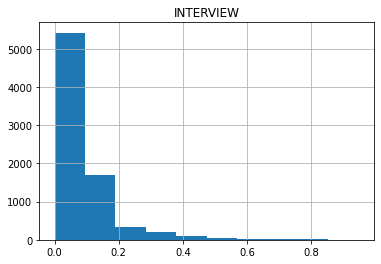

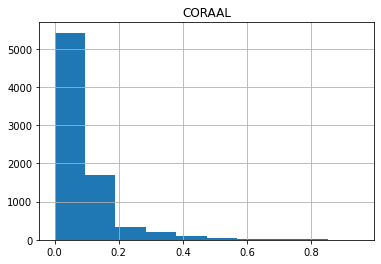

In [4]:
df_interviews.score.hist()
plt.title('INTERVIEW')
plt.show()

df_interviews.score.hist()
plt.title('CORAAL')
plt.show()

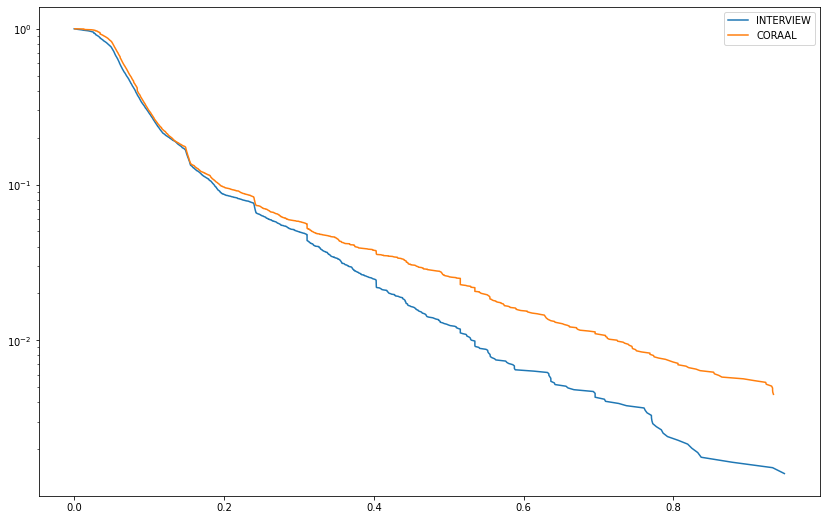

In [5]:
figure, ax = plt.subplots(figsize=(14,9))

ecdf_i = ECDF(df_interviews.score)
ecdf_c = ECDF(df_coraal.score)

ax.plot(ecdf_i.x, 1-ecdf_i.y, label="INTERVIEW")
ax.plot(ecdf_c.x, 1-ecdf_c.y, label="CORAAL")
ax.set(yscale='log')

plt.legend()
plt.show()


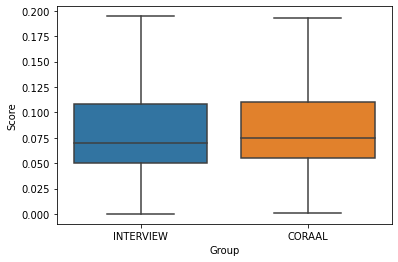

In [6]:
sns.boxplot(data=df, x="corpus", y="score", showfliers=False)
plt.xlabel("Group")
plt.ylabel("Score")

plt.show()

In [7]:
statistic, p_value = ks_2samp(
    df[df.corpus == 'CORAAL'].score,
    df[df.corpus == 'INTERVIEW'].score
)
statistic, p_value

(0.0708485857211845, 1.758988119569288e-16)